In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud


In [2]:
#数据导入
file_path = './Problem_C_Data/pacifier.tsv'
df = pd.read_csv(file_path, sep='\t', header=0)
df['review_body'][1]

'My little girl love this paci contraption!'

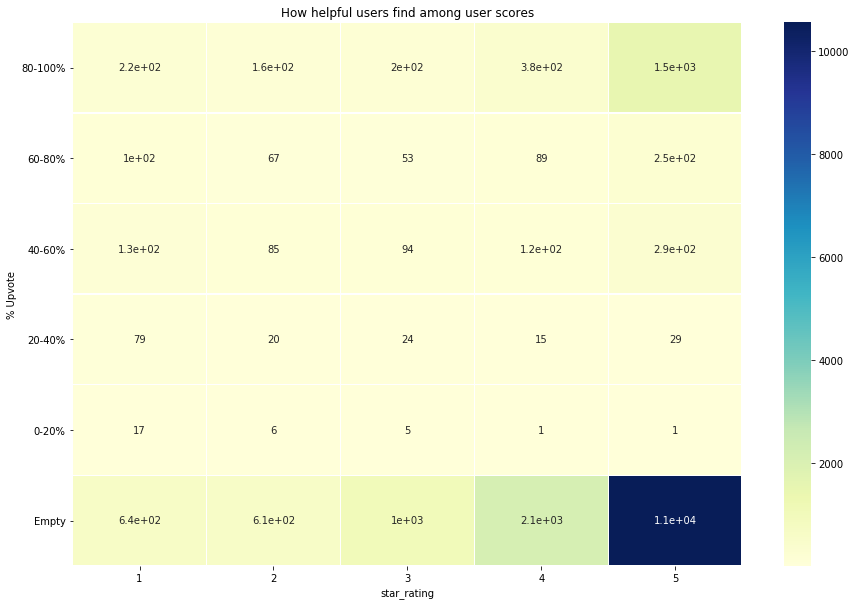

In [3]:
df['Helpful %'] = np.where(df['helpful_votes'] > 0, df['helpful_votes'] / df['total_votes'], -1)
df['% Upvote'] = pd.cut(df['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
df.head()

df_s = df.groupby(['star_rating', '% Upvote']).agg({'review_id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))

sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = 'YlGnBu', linewidths=.5, annot = True)
plt.yticks(rotation=0)
plt.title('How helpful users find among user scores')
plt.show()

In [4]:
df_s.head()

% Upvote,Empty,0-20%,20-40%,40-60%,60-80%,80-100%
star_rating,,,,,,
1,638,17,79,130,103,225
2,609,6,20,85,67,158
3,1049,5,24,94,53,201
4,2111,1,15,115,89,385
5,10565,1,29,291,250,1524


In [5]:
#保留不是3的评论
filtered_data = df[df['star_rating'] != 3]
def partition(x):
    if x>3:
        return 'positive'
    return 'negative'

actual_score = filtered_data['star_rating']
positiveNegative = actual_score.map(partition)
filtered_data['Score'] = positiveNegative
filtered_data.head()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,Helpful %,% Upvote,Score
0,US,40626522,R1A3ZUBR8TSAKY,B00793CZAE,572944212,"mary meyer wubbanub plush pacifier, lamb",Baby,5,0,0,N,Y,Love this!,Perfect match for the Gund Huggybuddy I bought...,8/31/2015,-1.0,Empty,positive
1,US,16290022,RLJNYBK4FGBYX,B003PCYMP4,911821018,wubbanub lamb infant pacifier,Baby,5,0,0,N,Y,Love 💕,My little girl love this paci contraption!,8/31/2015,-1.0,Empty,positive
2,US,10216509,R26QCW75C4JDOK,B003CK3LDI,392768822,wubbanub infant pacifier - giraffe,Baby,5,0,0,N,Y,Five Stars,My son loves this one and will only sleep if h...,8/31/2015,-1.0,Empty,positive
3,US,114040,R2E7N0TVLUHUDR,B003CK3LDI,392768822,wubbanub infant pacifier - giraffe,Baby,5,0,0,N,Y,Five Stars,Perfect,8/31/2015,-1.0,Empty,positive
4,US,27971579,R1SO9VMCIGZX3U,B003PCYMP4,911821018,wubbanub lamb infant pacifier,Baby,5,0,0,N,Y,Five Stars,Amazing addition to the nursery!,8/31/2015,-1.0,Empty,positive


In [61]:
import re

# Sorting data points according to the 'ProductId'
sorted_data = filtered_data.sort_values('product_id', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Eliminating the duplicate data points based on: 'UserId', 'ProfileName', 'Time', 'Summary'
final = sorted_data.drop_duplicates(subset={'review_id', 'product_title', 'review_date', 'review_body'}, keep='first', inplace=False)

# Eliminating the row where 'HelpfulnessDenominator' is greater than 'HelpfulnessNumerator' as these are the wrong entry
final = final[final['total_votes'] >= final['helpful_votes']]

# Getting shape of final data frame
display(final.shape)


# Creating the set of stopwords
stop = set(stopwords.words('english'))

# For stemming purpose
snow = nltk.stem.SnowballStemmer('english')

# Defining function to clean html tags
def cleanhtml(sentence):
    cleaner = re.compile('<.*>')
    cleantext = re.sub(cleaner, ' ', sentence)
    return cleantext

# Defining function to remove special symbols
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|.|!|*|@|#|\'|"|,|)|(|\|/]', r'', sentence)
    return cleaned


# Important steps to clean the text data. Please trace it out carefully
i = 0
str1 = ''
all_positive_words = []
all_negative_words = []
final_string = []
s=''
for sent in final['review_body'].values:
    filtered_sentence = []
    sent = cleanhtml(str(sent))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if (cleaned_words.lower() not in stop):
                    s = (snow.stem(cleaned_words.lower())).encode('utf-8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_words.append(s)
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence)
    final_string.append(str1)
    i += 1
    
# Adding new column into dataframe to store cleaned text
final['CleanedText'] = final_string
final['CleanedText'] = final['CleanedText'].str.decode('utf-8')


# Getting shape of new datset
print(final.shape)

(17513, 18)

(17513, 19)


In [62]:
X = final['CleanedText']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = final['star_rating'].map(y_dict)

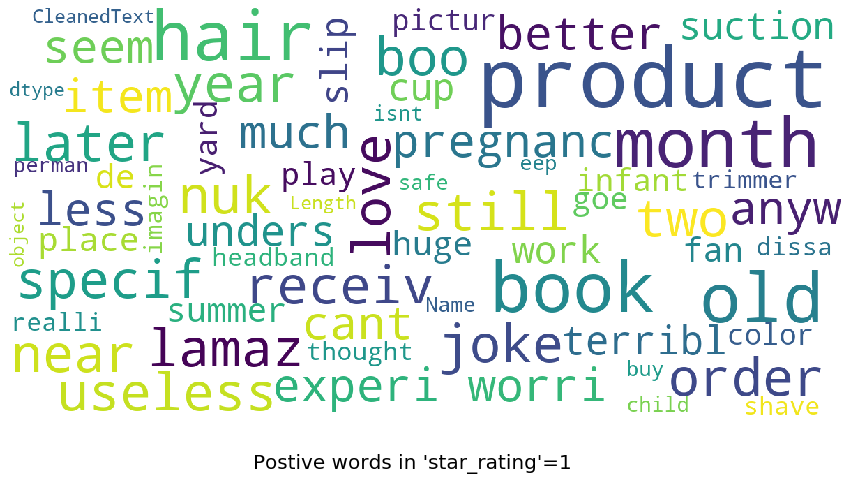

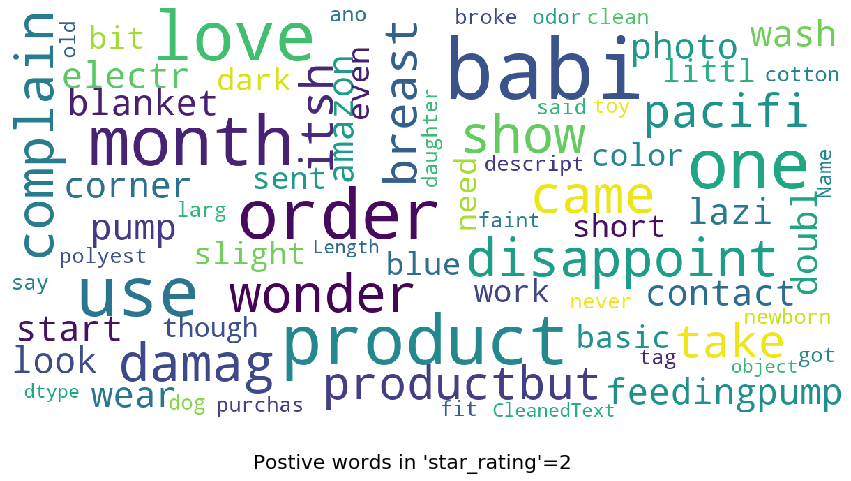

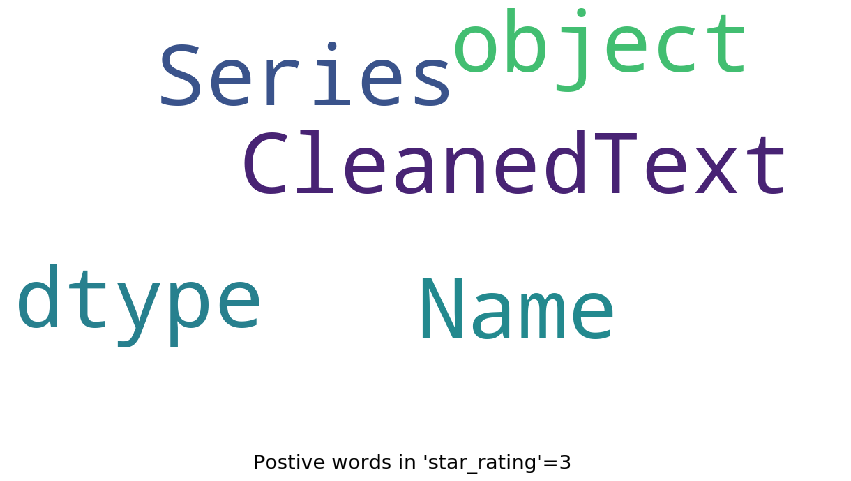

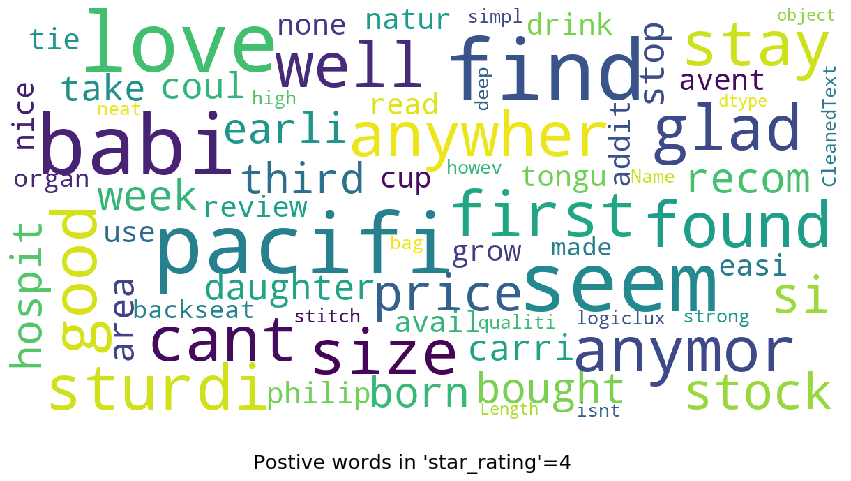

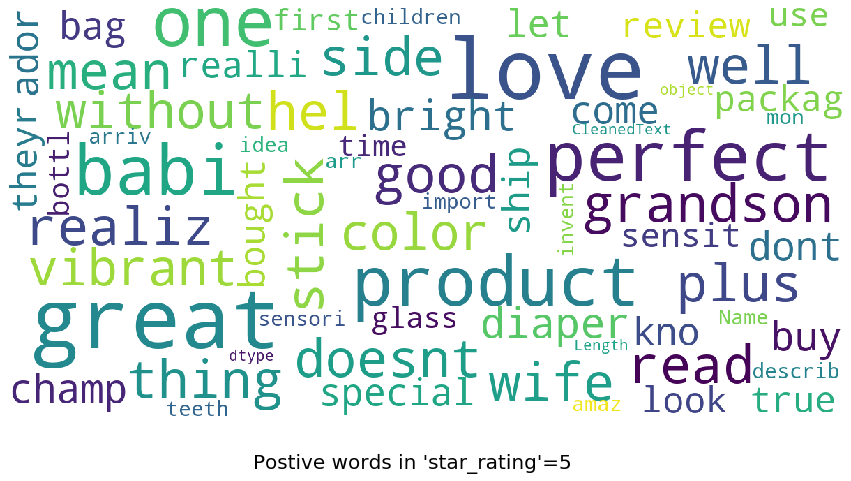

In [63]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
import matplotlib as mpl


mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
        
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
for i in range(1,6):
    show_wordcloud(final['CleanedText'][final.star_rating == i] , title="Postive words in 'star_rating'="+str(i))


In [64]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))

    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))
    return coeff_df
    
    
coeff_df = text_fit(X, y, c, LogisticRegression())

# features: 10610
# train records: 13134
# test records: 4379


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model Accuracy: 0.9127654715688513

-Top 20 positive-
      Word  Coefficient
     excel     2.143353
   perfect     2.036688
     worri     1.991320
      glad     1.979265
    awesom     1.894336
      love     1.876666
    easier     1.810559
     handi     1.738808
   favorit     1.646420
     great     1.630284
     funni     1.625092
      easi     1.608358
   teether     1.597861
    wonder     1.441809
      nice     1.420463
   channel     1.402855
    sturdi     1.389037
      ador     1.353306
      best     1.335838
 complaint     1.327503

-Top 20 negative-
       Word  Coefficient
    terribl    -1.524826
    wouldnt    -1.572394
        gap    -1.590495
        sad    -1.614060
      inner    -1.637832
      worst    -1.637996
       idea    -1.638844
    attempt    -1.650939
      fuzzi    -1.729908
       poor    -1.758369
     flimsi    -1.821026
     theori    -1.826191
       hate    -1.829438
       bare    -1.834387
    concept    -1.838078
      broke    -1.98652

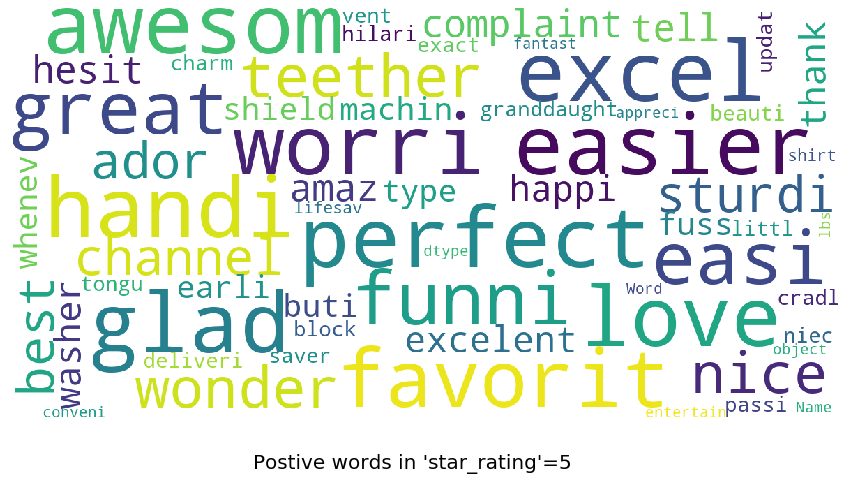

In [68]:
coeff_df
show_wordcloud(coeff_df['Word'][coeff_df['Coefficient']>1] , title="Postive words in 'star_rating'=5")

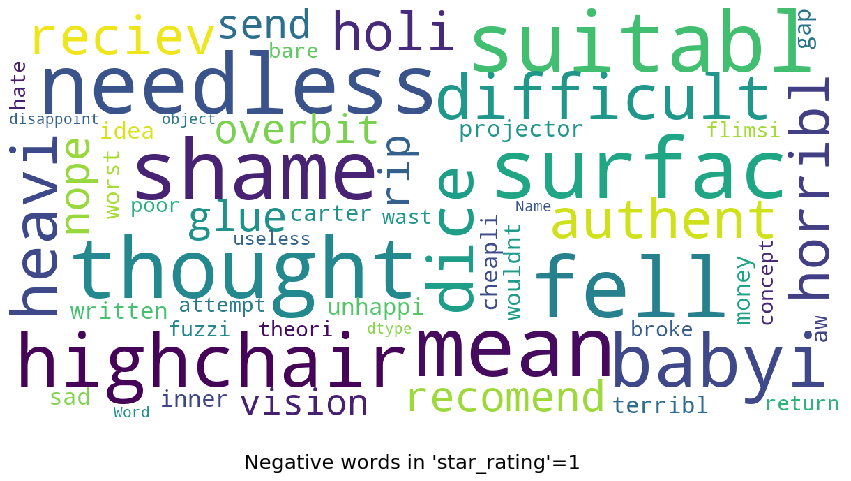

In [72]:
show_wordcloud(coeff_df['Word'][coeff_df['Coefficient']<-1.2] , title="Negative words in 'star_rating'=1")

In [ ]:
df = df[df['star_rating'] == 5]
df = df[df['% Upvote'].isin(['0-20%', '20-40%', '60-80%', '80-100%'])]
df.shape

X = df['review_body']
y_dict = {'0-20%': 0, '20-40%': 0, '60-80%': 1, '80-100%': 1}
y = df['% Upvote'].map(y_dict)

print('Class distribution:')
print(y.value_counts())

In [33]:
df_s = pd.DataFrame(data = [X,y]).T

Downvote_records = len(df_s[df_s['% Upvote'] == 0])
Downvote_indices = np.array(df_s[df_s['% Upvote'] == 0].index)

Upvote_indices = df_s[df_s['% Upvote'] == 1].index

random_upvote_indices = np.random.choice(Upvote_indices, Downvote_records, replace = False)
random_upvote_indices = np.array(random_upvote_indices)

under_sample_indices = np.concatenate([Downvote_indices,random_upvote_indices])

under_sample_data = df_s.ix[under_sample_indices, :]
X_u = under_sample_data['review_body']
under_sample_data['% Upvote'] = under_sample_data['% Upvote'].astype(int)
y_u = under_sample_data['% Upvote']


print("Percentage of upvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 1])/len(under_sample_data))
print("Percentage of downvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 0])/len(under_sample_data))
print("Total number of records in resampled data: ", len(under_sample_data))

#pd.set_option('display.max_colwidth', -1)
print('Downvote score 5 comments examples:')
print(under_sample_data[under_sample_data['% Upvote']==0]['review_body'].iloc[:100:20])
print('Upvote score 5 comments examples')
print(under_sample_data[under_sample_data['% Upvote']==1]['review_body'].iloc[:100:20])

Percentage of upvote transactions:  0.5
Percentage of downvote transactions:  0.5
Total number of records in resampled data:  34
Downvote score 5 comments examples:
726    I don't write many reviews; but this hair drye...
Name: review_body, dtype: object
Upvote score 5 comments examples
11432    I bought this hair dryer for my wife who told ...
Name: review_body, dtype: object


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


In [34]:
under_sample_data['word_count'] = under_sample_data['review_body'].apply(lambda x: len(x.split()))
under_sample_data['capital_count'] = under_sample_data['review_body'].apply(lambda x: sum(1 for c in x if c.isupper()))
under_sample_data['question_mark'] = under_sample_data['review_body'].apply(lambda x: sum(1 for c in x if c == '?'))
under_sample_data['exclamation_mark'] = under_sample_data['review_body'].apply(lambda x: sum(1 for c in x if c == '!'))
under_sample_data['punctuation'] = under_sample_data['review_body'].apply(lambda x: sum(1 for c in x if c in punctuation))

print(under_sample_data.groupby('% Upvote').agg({'word_count': 'mean', 'capital_count': 'mean', 'question_mark': 'mean', 'exclamation_mark': 'mean', 'punctuation': 'mean'}).T)

X_num = under_sample_data[under_sample_data.columns.difference(['% Upvote', 'Text'])]
y_num = under_sample_data['% Upvote']

% Upvote                  0          1
word_count        86.647059  72.000000
capital_count     17.411765   8.941176
question_mark      0.117647   0.000000
exclamation_mark   0.588235   0.764706
punctuation       22.941176  11.235294


In [72]:
df_user = df.groupby(['customer_id']).agg({'star_rating':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)
df_user.columns = ['Score count', 'Score mean']
df_user = df_user.sort_values(by = 'Score count', ascending = False)
print(df_user.head(10))

             Score count  Score mean
customer_id                         
36454574               2           5
16041952               2           5
44899760               2           5
34757787               2           5
11773102               2           5
28676394               2           5
18625890               2           5
42689422               2           5
12597127               2           5
39804327               1           5


In [84]:
def get_token_adj(score, benchmark, odf,userid='all'):
    
    if userid != 'all':
        df = odf[(odf['customer_id'] == userid) & (odf['star_rating'] == score)]['review_body']
    else:
        df = odf[odf['star_rating'] == score]['review_body']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'a') for w in total_text]
    # get adjective only
    total_text = [word for word, form in nltk.pos_tag(total_text) if form == 'JJ']
    

    text = nltk.Text(total_text)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1]),text

In [86]:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

total_texts = []
for j in range(1,6):
    test = pd.DataFrame()
    d,total_text = get_token_adj(j, 0.05,df)
    total_texts.append(total_text)
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
#     test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
Empty DataFrame
Columns: []
Index: []
score 2 reviews most popular adjectives word:
Empty DataFrame
Columns: []
Index: []
score 3 reviews most popular adjectives word:
Empty DataFrame
Columns: []
Index: []
score 4 reviews most popular adjectives word:
Empty DataFrame
Columns: []
Index: []
score 5 reviews most popular adjectives word:
     Count  Occur %     Phrase
0   2507.0  148.52%        dry
1    653.0   38.68%      great
2    494.0   29.27%       good
3    343.0   20.32%       hair
4    265.0    15.7%        old
5    260.0    15.4%        hot
6    254.0   15.05%     little
7    242.0   14.34%       high
8    234.0   13.86%       easy
9    229.0   13.57%       much
10   197.0   11.67%      quiet
11   177.0   10.49%   powerful
12   175.0   10.37%      small
13   173.0   10.25%        low
14   169.0   10.01%       nice
15   160.0    9.48%       long
16   153.0    9.06%        new
17   145.0    8.59%      happy
18   134.0    7.94%      thic

In [83]:
for i in total_texts:
    print(i)

[]
[]
[]
[]
['reckon', 'great', 'doesnt', 'big', 'quick', 'much', 'little', 'hair', 'much', 'first', 'dust', 'small', 'lightweight', 'powerful', 'dry', 'short', 'sweet', 'little', 'dry', 'dry', 'high', 'low', 'fast', 'third', 'hot', 'bonnet', 'dry', 'recommend', 'hose', 'second', 'dry', 'connected', 'dry', 'heist', 'low', '10-15', 'hot', 'ionic', 'dry', 'great', 'purple', 'black', 'high', 'low', 'high', 'low', 'ionic', 'adjustable', 'pole', 'great', 'easy', 'much', 'good', 'dry', 'table', 'chair', 'low', 'dry', 'weekly', 'flip', 'dry', 'large', 'dry', 'dry', 'dry', 'amazing', 'pleased', 'hot', 'pink', 'mini-pro', 'powerful', 'super', 'perfect', 'big', 'heavy', 'dry', 'little', 'baby', 'hot', 'low', 'shoulder/', 'dry', 'awesome', 'dry', 'fine', 'fizzy', 'dry', 'soft', 'hair', 'healthy', 'like', 'exact', 'comfortable', 'hold', 'thick', 'easy', 'hair', 'smooth', 'old', 'different', 'expensive', 'exact', 'find', 'good', 'click', '1-click', 'ceramic', 'negative', 'gentle', 'hair', 'fast', '

In [39]:
show_wordcloud(final['CleanedText'][final.star_rating == 2] , title="Negitive words in 'star_rating'=2")


10544    peroxyl isnt avail live shipment slower expect...
10309    last penlet die pretti quick one seem lot soli...
10492    product nice beigey glosscannot find store any...
11287    order new current one die littl two year use n...
11468    hairdryer far exceed expect high recommend fin...
                               ...                        
181      hairdryer noisi past prime delight tri new rem...
180      road vacat brought dryer long hair swim lot ch...
51       nice hair blow dryer color love medium shade p...
344      blow dryer arriv compliment vine program suppo...
281      excel hair dryer impress control could littl e...
Name: CleanedText, Length: 10471, dtype: object